In [2]:
!pip freeze | grep -E "qiskit|pyscf"

pyscf==2.8.0
qiskit==0.44.0
qiskit-aer==0.12.0
qiskit-nature==0.6.2
qiskit-terra==0.25.0


# VQE on Aer Simulator with Noise

In [3]:
import warnings

warnings.filterwarnings("ignore")

### Electronic Structure problem and Qubit Operator

In [21]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.units import DistanceUnit as UnitsType
from qiskit_nature.second_q.drivers import ElectronicStructureDriver, PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import (
    ParityMapper,
    JordanWignerMapper,
    BravyiKitaevMapper,
)
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCC, UCCSD, HartreeFock
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_aer import AerSimulator as Aer
from qiskit_aer.primitives import Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

In [2]:
molecule = MoleculeInfo(
    symbols=["H", "H"],
    coords=np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.735]]),
    multiplicity=1,
    charge=0,
    units=UnitsType.ANGSTROM,
)

In [3]:
driver = PySCFDriver.from_molecule(molecule, basis="sto-3g")
problem = driver.run()

In [4]:
num_alpha_electrons = problem.num_alpha
num_beta_electrons = problem.num_beta
num_spin_orbitals = int(problem.num_spin_orbitals)

nuclear_rep_energy = problem.nuclear_repulsion_energy
print("number of alpha electrons: ", num_alpha_electrons)
print("number of beta electrons: ", num_beta_electrons)
print("number of spin orbitals: ", num_spin_orbitals)
print("nuclear repulsion energy: ", nuclear_rep_energy)

number of alpha electrons:  1
number of beta electrons:  1
number of spin orbitals:  4
nuclear repulsion energy:  0.7199689944489797


In [6]:
# Define the active space around the Fermi level
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2,  # Number of electrons in our active space
    num_spatial_orbitals=2,  # Number of orbitals in our active space
    # active_orbitals=[18,19]
)
# Now you can get the reduced electronic structure problem
problem_reduced = transformer.transform(problem)

second_q_ops_reduced = problem_reduced.second_q_ops()
second_q_ops_reduced

(FermionicOp({'+_0 -_0': np.float64(-1.2563390730032498), '+_1 -_1': np.float64(-0.4718960072811422), '+_2 -_2': np.float64(-1.2563390730032498), '+_3 -_3': np.float64(-0.4718960072811422), '+_0 +_0 -_0 -_0': np.float64(0.33785507740175813), '+_0 +_1 -_1 -_0': np.float64(0.3322908651276482), '+_0 +_2 -_2 -_0': np.float64(0.33785507740175813), '+_0 +_3 -_3 -_0': np.float64(0.3322908651276482), '+_0 +_0 -_1 -_1': np.float64(0.09046559989211572), '+_0 +_1 -_0 -_1': np.float64(0.09046559989211572), '+_0 +_2 -_3 -_1': np.float64(0.09046559989211572), '+_0 +_3 -_2 -_1': np.float64(0.09046559989211572), '+_1 +_0 -_1 -_0': np.float64(0.09046559989211572), '+_1 +_1 -_0 -_0': np.float64(0.09046559989211572), '+_1 +_2 -_3 -_0': np.float64(0.09046559989211572), '+_1 +_3 -_2 -_0': np.float64(0.09046559989211572), '+_1 +_0 -_0 -_1': np.float64(0.3322908651276482), '+_1 +_1 -_1 -_1': np.float64(0.34928686136600884), '+_1 +_2 -_2 -_1': np.float64(0.3322908651276482), '+_1 +_3 -_3 -_1': np.float64(0.34

In [7]:
# no need for two_qubit_reduction=True, it's automatic
parity_mapper = ParityMapper(num_particles=problem_reduced.num_particles)
qubit_op_parity = parity_mapper.map(second_q_ops_reduced[0])

print(qubit_op_parity)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


### Exact Solution

In [8]:
numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(parity_mapper, numpy_solver)
real_solution_t = solver.solve(problem_reduced).total_energies[0]
# real_solution_t = solver.solve(problem_reduced)
print("Reference energy : ", real_solution_t)

Reference energy :  -1.1373060357534017


In [9]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_parity)
# print(result)
ref_value = result.eigenvalue.real
print(f"Reference energy: {ref_value:.5f}")

Reference energy: -1.85728


In [10]:
solution = solver.solve(problem_reduced)
active_space_energy = solution.extracted_transformer_energy
print("active_space_energy: ", active_space_energy)

active_space_energy:  0.0


### Creating Ansatz

Number of parameters in RY ansatz: 4
Depth of RY ansatz: 5


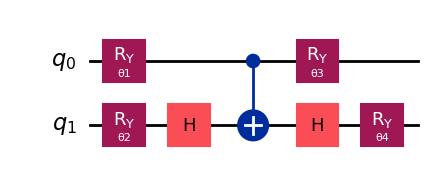

In [11]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta_1, theta_2, theta_3, theta_4 = (
    Parameter("θ1"),
    Parameter("θ2"),
    Parameter("θ3"),
    Parameter("θ4"),
)
ansatz = QuantumCircuit(2)
ansatz.ry(theta_1, 0)
ansatz.ry(theta_2, 1)
ansatz.h(1)
ansatz.cx(0, 1)
ansatz.h(1)
ansatz.ry(theta_3, 0)
ansatz.ry(theta_4, 1)
print("Number of parameters in RY ansatz:", len(ansatz.parameters))
print("Depth of RY ansatz:", ansatz.depth())
ansatz.draw("mpl")

Number of parameters in UCC ansatz: 3
Depth of UCC ansatz: 4


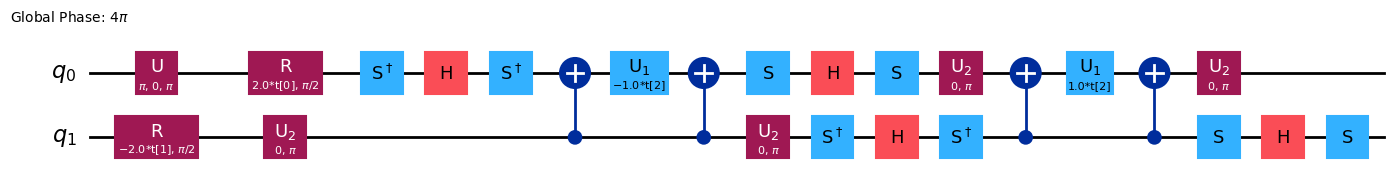

In [12]:
init_state = HartreeFock(
    num_spatial_orbitals=problem_reduced.num_spatial_orbitals,
    num_particles=problem_reduced.num_particles,
    qubit_mapper=parity_mapper,
)
ansatz_ucc = UCC(
    qubit_mapper=parity_mapper,
    num_particles=problem_reduced.num_particles,
    num_spatial_orbitals=problem_reduced.num_spatial_orbitals,
    excitations="sd",
    initial_state=init_state,
)
print("Number of parameters in UCC ansatz:", len(ansatz_ucc.parameters))
print("Depth of UCC ansatz:", ansatz_ucc.decompose().depth())
ansatz_ucc.decompose(reps=3).draw("mpl")

## Performance without noise

In [14]:
shots, iterations = 100_000, 125

backend = Aer()
estimator = Estimator()

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


ansatz = ansatz_ucc
# ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.84835
Delta from reference energy value is 0.00892


In [16]:
import matplotlib.pyplot as plt

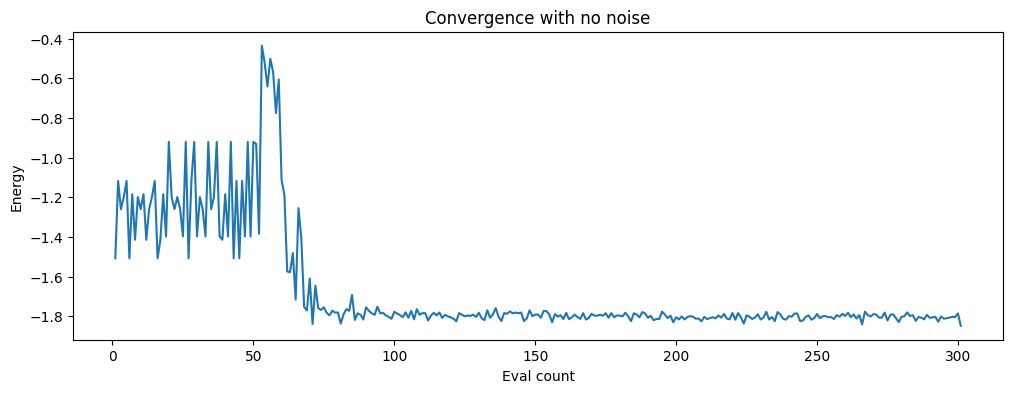

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(counts, values)
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.title("Convergence with no noise")
plt.show()

## Performance with noise

Here we will create a noise model for Aer from an actual device.

First we need to get an actual device backend and from its `configuration` and `properties` we can setup a coupling map and a noise model to match the device.

Note: simulation with noise will take longer than without noise.

Terra Mock Backends:

We will use real noise data for an IBM Quantum device using the date stored in Qiskit Terra. Specifically, in this tutorial, the device is ibmq_vigo.

In [ ]:
device_backend = FakeManilaV2()

counts1 = []
values1 = []
noise_model = NoiseModel.from_backend(FakeManilaV2())

backend_options = {"noise_model": noise_model}
noisy_estimator = Estimator(backend_options=backend_options)

print(noise_model)


def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)


# var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(estimator, ansatz_ucc, optimizer=spsa, callback=store_intermediate_result1)
result1 = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}"
)

NoiseModel:
  Basis gates: ['cx', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'sx', 'cx', 'measure', 'x', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (3, 4)), ('cx', (4, 3)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
VQE on Aer qasm simulator (with noise): -1.86065
Delta from reference energy value is -0.00338


Text(0.5, 1.0, 'Convergence with noise')

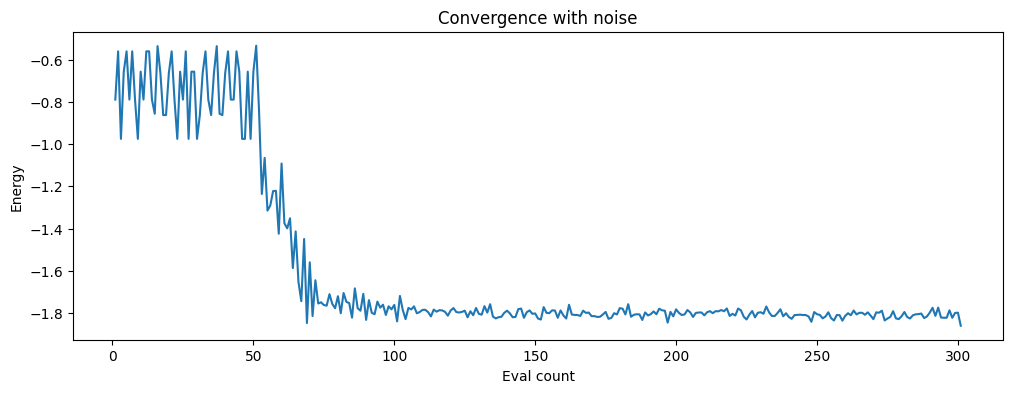

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(counts1, values1)
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.title("Convergence with noise")